**Problems**: We want to generate handwritten digits.

**Data**: The 28 x 28 pixel images of MNIST  database:

![MnistExamples](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)


**Reference**: [github.com/eriklindernoren/Keras-GAN](https://github.com/eriklindernoren/Keras-GAN)



 

In [1]:
# import libraries
import numpy as np
import keras
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, Reshape, UpSampling2D, BatchNormalization, MaxPooling2D, Activation, LeakyReLU, ZeroPadding2D
from keras import backend as K

In [60]:
# dimension of latent space
latent_dim = 100

# input image dimensions
img_rows, img_cols, img_channels = 32, 32, 3

# read the training and the test data sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# reshape input to match the network format
input_shape = (img_rows, img_cols, img_channels)

# preprocessing
x_train = x_train.astype('float32') / 128 - 1.0
# x_train = np.expand_dims(x_train, -1)

# print dataset size
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples


In [57]:
# funtion to show images  
def show_imgs(imgs, r, c):
  import matplotlib.pyplot as plt 
  from IPython.display import clear_output
  fig = plt.figure(figsize=(4*c,4*r))
  axs = fig.subplots(r, c)
  cnt = 0
  for i in range(r):
      for j in range(c):
          axs[i,j].imshow(imgs[cnt, :,:])
          axs[i,j].axis('off')
          cnt += 1
  clear_output(wait=True)
  plt.show()

## **Generator**


In [40]:
generator = Sequential()

generator.add(Dense(128 * 8 * 8, activation="relu", input_dim=latent_dim))
generator.add(Reshape((8, 8, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(128, kernel_size=3, padding="same"))
generator.add(BatchNormalization(axis=-1, momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=3, padding="same"))
generator.add(BatchNormalization(axis=-1, momentum=0.8))
generator.add(Activation("relu"))
generator.add(Conv2D(img_channels, kernel_size=3, padding="same"))
generator.add(Activation("tanh"))

generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8192)              827392    
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 up_sampling2d_4 (UpSampling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 batch_normalization_10 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 16, 16, 128)      

# Discriminator

In [41]:
discriminator = Sequential()

discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=input_shape, padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))

discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(axis=-1, momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))

discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(axis=-1, momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))

discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(axis=-1, momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))

discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 16, 16, 32)        896       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                                 
 dropout_8 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 batch_normalization_12 (Bat  (None, 8, 8, 64)         256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 8, 8, 64)          0         
                                                      

# **Combinate**




In [42]:
# Algorithm of optimization
optimizer = keras.optimizers.adam_v2.Adam(0.0002, 0.5)

# Compile the discriminator
discriminator.trainable = True
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer,
                      metrics=['accuracy'])


# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)


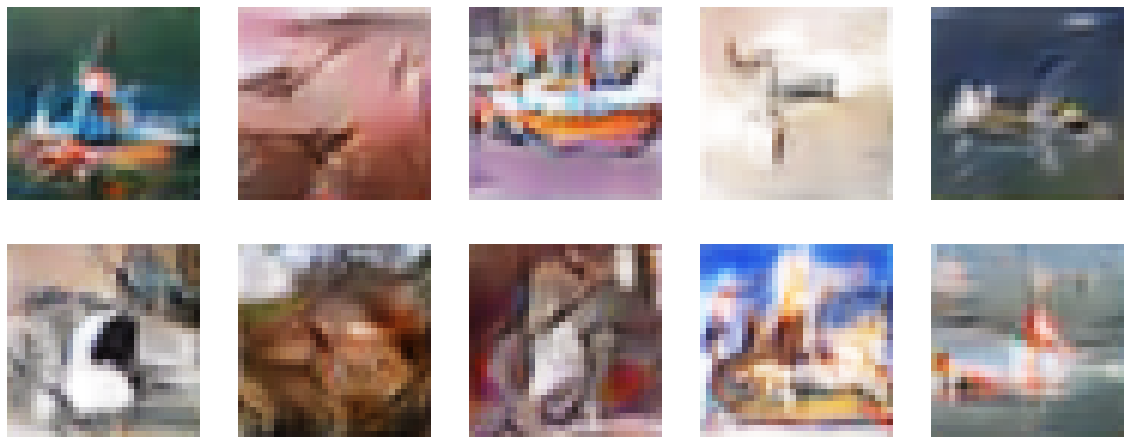

	Generated after 22500 interetions

22546 [Discriminator loss: 0.656992, acc.: 59.38%] [Generator loss: 0.812453]

In [ ]:
# training parameters
iterations = 30000
batch_size = 64
show_interval = 100
plot_r, plot_c = 2, 5

# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

# train loop
for index in range(iterations):

  # ---------------------
  #  Show generated images
  # ---------------------
  if index % show_interval == 0:
    # Sample noise and generate images
    noise = np.random.randn(plot_r*plot_c, latent_dim)
    gen_imgs = generator.predict(noise)
    
    # postprocessing
    gen_imgs = (128 * gen_imgs + 128).clip(0,255).astype(np.uint8)
    # gen_imgs = gen_imgs[:,:,:,0]
    
    
    # show generated images
    show_imgs(gen_imgs, plot_r, plot_c)
    print('\tGenerated after %d interetions'% index)
    print()
    
  # ---------------------
  #  Train Discriminator
  # ---------------------

  # Select a random half of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  imgs = x_train[idx]

  # Sample noise and generate a batch of new images
  noise = np.random.randn(batch_size, latent_dim)
  gen_imgs = generator.predict(noise)

  # Train the discriminator (real classified as ones and generated as zeros)
  discriminator.trainable = True
  d_loss = discriminator.train_on_batch(
      np.concatenate((imgs, gen_imgs)),
      np.concatenate((valid, fake))# + 0.05 * np.random.uniform(size=(2*batch_size, 1))
      )

  # ---------------------
  #  Train Generator
  # ---------------------

  # Train the generator (wants discriminator to mistake images as real)
  discriminator.trainable = False
  g_loss = combined.train_on_batch(noise, valid)

  # Print the progress
  print("\r%5d [Discriminator loss: %5f, acc.: %.2f%%] [Generator loss: %5f]" % (index, d_loss[0], 100*d_loss[1], g_loss) , end='')


#Further reading

[Generative keras examples](https://keras.io/examples/generative/)

[Create a GAN keras model](https://keras.io/examples/generative/dcgan_overriding_train_step/)

